In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from neurodsp.filt import filter_signal
from bycycle.features import compute_features
import os
import h5py
sns.set_style('whitegrid')
plt.style.use('Cole_2018.mplstyle')

from scipy import stats
import itertools
import matplotlib.mlab as mlab
import pickle

from config import config_dict

In [2]:
# Make directory for saving figures
if not os.path.exists('figs/1'):
    os.makedirs('figs/1')

# A-B. Example LFP

In [3]:
# Load dataframe of cycle feature statistics for each shank
df_shanks = pd.read_csv(config_dict['processed_path'] + 'df_shanks_stats.csv', index_col=0)
df_shanks = df_shanks[df_shanks['burst_type']==0].reset_index()

# Load lfp
shank_idx = 0
rat, sess, sh, Fs, elec = df_shanks.loc[shank_idx, ['rat', 'sess', 'sh', 'Fs', 'elec']]

lfp_filename = config_dict['mat_path'] + rat + '/' + sess + '/' + str(sh) + '/lfp' + str(elec) + '.mat'
f = h5py.File(lfp_filename)
lfp = np.array(f['lfp']).T[0]
t = np.arange(0, len(lfp)/Fs, 1/Fs)

# Filter lfp
lfp_filt = filter_signal(lfp, Fs, 'lowpass', fc=config_dict['cf_low'],
                         n_seconds=config_dict['N_seconds_low'], remove_edge_artifacts=False)
lfp_filt = filter_signal(lfp_filt, Fs, 'highpass', fc=config_dict['cf_high'],
                         n_seconds=config_dict['N_seconds_high'], remove_edge_artifacts=False)

osc_kwargs = config_dict['burst_kwargs_list'][0]

# Compute shape
df = compute_features(lfp_filt, Fs, config_dict['f_range'],
                      center_extrema=config_dict['extrema_center'],
                      burst_detection_kwargs=osc_kwargs)

Transition bandwidth is 2.4 Hz. Pass/stop bandwidth is 25 Hz
Transition bandwidth is 0.0 Hz. Pass/stop bandwidth is 624.0 Hz


/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


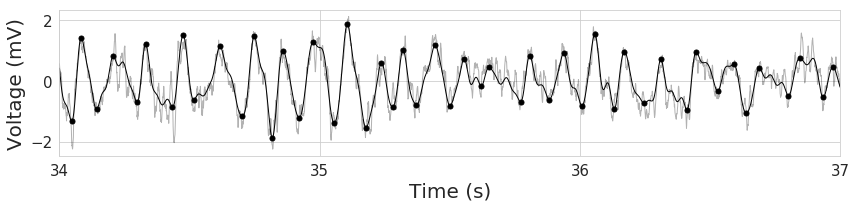

In [4]:
# Determine peak and trough times
tlim = (34, 37)
troughs = df['sample_trough'][(df['sample_trough'] > tlim[0]*Fs) &
                                    (df['sample_trough'] < tlim[1]*Fs)]
peaks = df['sample_last_peak'][(df['sample_last_peak'] > tlim[0]*Fs) &
                                    (df['sample_last_peak'] < tlim[1]*Fs)]
tidx = np.logical_and(t >= tlim[0], t <= tlim[1])

# Plot example lfp trace
plt.figure(figsize=(12,3))
plt.plot(t[tidx], lfp[tidx]/1000, 'k', alpha=.3)
plt.plot(t[tidx], lfp_filt[tidx]/1000, 'k')
plt.plot(t[troughs], lfp_filt[troughs]/1000, 'k.')
plt.plot(t[peaks], lfp_filt[peaks]/1000, 'k.')
plt.xlim(tlim)
plt.xticks(np.arange(tlim[0], tlim[1]+1))
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.tight_layout()
plt.savefig('figs/1/A.png')

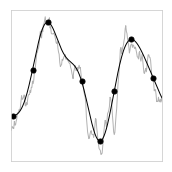

In [5]:
# Plot example lfp trace
tlim = (34.7, 34.9)
troughs = df['sample_trough'][(df['sample_trough'] > tlim[0]*Fs) &
                                    (df['sample_trough'] < tlim[1]*Fs)]
peaks = df['sample_last_peak'][(df['sample_last_peak'] > tlim[0]*Fs) &
                                    (df['sample_last_peak'] < tlim[1]*Fs)]
zeroxr = df['sample_zerox_rise'][(df['sample_zerox_rise'] > tlim[0]*Fs) &
                                    (df['sample_zerox_rise'] < tlim[1]*Fs)]
zeroxd = df['sample_zerox_decay'][(df['sample_zerox_decay'] > tlim[0]*Fs) &
                                    (df['sample_zerox_decay'] < tlim[1]*Fs)]

tidx = np.logical_and(t >= tlim[0], t <= tlim[1])
plt.figure(figsize=(2.5, 2.5))
plt.plot(t[tidx], lfp[tidx]/1000, 'k', alpha=.3)
plt.plot(t[tidx], lfp_filt[tidx]/1000, 'k')
plt.plot(t[troughs], lfp_filt[troughs]/1000, 'k.')
plt.plot(t[peaks], lfp_filt[peaks]/1000, 'k.')
plt.plot(t[zeroxr], lfp_filt[zeroxr]/1000, 'k.')
plt.plot(t[zeroxd], lfp_filt[zeroxd]/1000, 'k.')
plt.xlim(tlim)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('figs/1/B.png')

# C-F. Distributions of mean cycle features

In [6]:
# Quantify fraction of recordings with rise-decay and peak-trough symmetries below 0.5
print('Fraction of recordings with rise-decay symmetry < 0.5: {:.2f}'.format(np.mean(df_shanks['rdsym_mean']<0.5)))
print('Fraction of recordings with peak-trough symmetry < 0.5: {:.2f}'.format(np.mean(df_shanks['ptsym_mean']<0.5)))

Fraction of recordings with rise-decay symmetry < 0.5: 0.93
Fraction of recordings with peak-trough symmetry < 0.5: 0.95


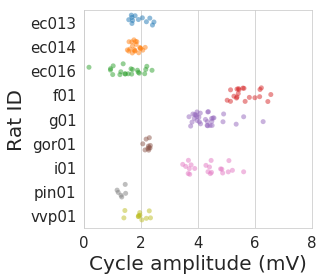

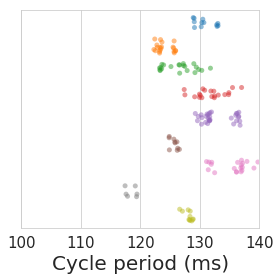

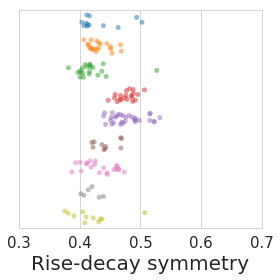

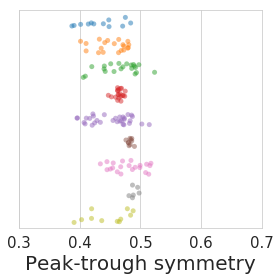

In [7]:
pltfmt = {'xticks': {'mv_amp_mean': np.arange(0,8.1,2),
                     'ms_period_mean': np.arange(100,141,10),
                     'rdsym_mean': np.arange(.3, .71, .1),
                     'ptsym_mean': np.arange(.3, .71, .1)},
          'xlabel': {'mv_amp_mean': 'Cycle amplitude (mV)',
                     'ms_period_mean': 'Cycle period (ms)',
                     'rdsym_mean': 'Rise-decay symmetry',
                     'ptsym_mean': 'Peak-trough symmetry'},
          'xlim': {'mv_amp_mean': (0, 8),
                     'ms_period_mean': (100, 140),
                     'rdsym_mean': (.3, .7),
                     'ptsym_mean': (.3, .7)},
          'letter': {'mv_amp_mean': 'C',
                     'ms_period_mean': 'D',
                     'rdsym_mean': 'E',
                     'ptsym_mean': 'F'}
         }

for feat in pltfmt['letter'].keys():
    # Compute figsize
    if feat == 'mv_amp_mean':
        figsize = (4.6,4)
    else:
        figsize = (4,4)
    plt.figure(figsize=figsize)
    
    # Make plot
    sns.stripplot(x=feat, y='rat', data=df_shanks, jitter=.3, alpha=.5)
    
    # Axis labels
    plt.xlim(pltfmt['xlim'][feat])
    plt.xlabel(pltfmt['xlabel'][feat])
    plt.xticks(pltfmt['xticks'][feat])
    if feat == 'mv_amp_mean':
        plt.ylabel('Rat ID')
    else:
        plt.ylabel('')
        plt.yticks([])

    # Save plot
    plt.tight_layout()
    plt.savefig('figs/1/{:s}.png'.format(pltfmt['letter'][feat]))

# D-F. Cycle feature correlation coefs across recordings

In [8]:
# Look at consistency in correlations between main features
feats = ['volt_amp', 'period', 'time_rdsym', 'time_ptsym']
print('N =', len(df_shanks))
for feat_pair in itertools.combinations(feats, 2):
    x = df_shanks['corr_{:s}_{:s}_r'.format(feat_pair[0], feat_pair[1])]
    r, p = stats.wilcoxon(x)
    print('{:10s} ~ {:10s}, W = {:4.0f}, p = {:.0E}, avg rho = {:.3f}'.format(feat_pair[0], feat_pair[1], r, p, np.mean(x)))

N = 152
volt_amp   ~ period    , W = 5098, p = 2E-01, avg rho = 0.009
volt_amp   ~ time_rdsym, W = 2740, p = 2E-08, avg rho = -0.025
volt_amp   ~ time_ptsym, W = 2368, p = 2E-10, avg rho = -0.036
period     ~ time_rdsym, W = 2835, p = 4E-08, avg rho = 0.038
period     ~ time_ptsym, W = 3781, p = 2E-04, avg rho = -0.018
time_rdsym ~ time_ptsym, W =   28, p = 2E-26, avg rho = -0.114


/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


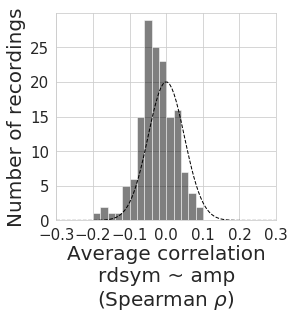

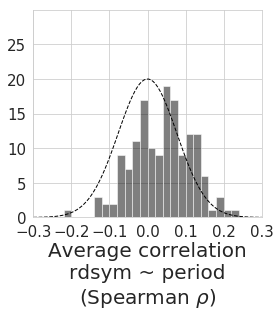

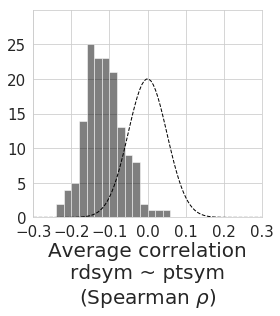

In [9]:
# Plot correlation scatters
pltfmt = {'letter': {'mv_amp': 'G',
                     'ms_period': 'H',
                     'time_ptsym': 'I'},
          'corrstr': {'mv_amp': 'volt_amp_time_rdsym',
                     'ms_period': 'period_time_rdsym',
                     'time_ptsym': 'time_rdsym_time_ptsym'},
          'short': {'mv_amp': 'amp',
                     'ms_period': 'period',
                     'time_ptsym': 'ptsym'},
          'lim': {'mv_amp': (1, 4),
                  'ms_period': (80, 180),
                  'time_ptsym': (.2, .8)},
          'ticks': {'mv_amp': np.linspace(1, 4, 4),
                  'ms_period': np.linspace(80, 180, 6),
                  'time_ptsym': np.linspace(.2, .8, 4)},
          'figsize': {'mv_amp': (4.2,4.5),
                  'ms_period': (4,4.5),
                  'time_ptsym': (4,4.5)}
         }
other_feats = ['mv_amp', 'ms_period', 'time_ptsym']
for feat in pltfmt['lim'].keys():
    plt.figure(figsize=pltfmt['figsize'][feat])
    histplt = df_shanks['corr_{:s}_r'.format(pltfmt['corrstr'][feat])]
    plt.hist(histplt, bins=np.arange(-.3,.31, .02), color='k', alpha=.5)
    
    # Plot null Gaussian
    x_gauss = np.linspace(-.3,.3, 100)
    y_gauss = mlab.normpdf(x_gauss, 0, np.std(histplt))
    y_gauss = y_gauss * 20 / np.max(y_gauss)
    plt.plot(x_gauss, y_gauss, 'k--')
    
    plt.xticks(np.arange(-.3,.32,.1))
    plt.xlim((-.3, .3))
    plt.yticks(np.arange(0, 30, 5))
    plt.ylim((0, 30))
    
    if feat == 'mv_amp':
        plt.ylabel('Number of recordings')
    plt.xlabel('Average correlation\nrdsym ~ '+pltfmt['short'][feat]+'\n(Spearman $\\rho$)')
    plt.tight_layout()
    plt.savefig('figs/1/{:s}.png'.format(pltfmt['letter'][feat]))

# G. Autocorrelations of cycle features

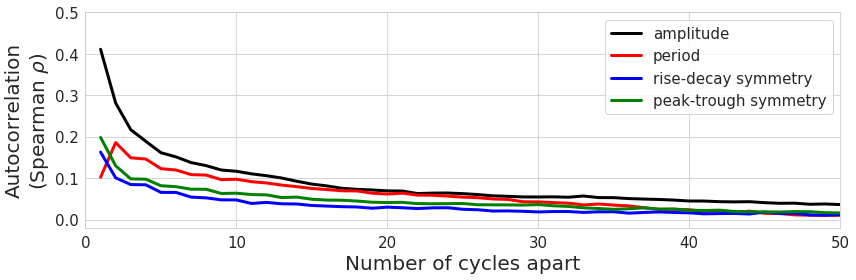

In [10]:
# Load autocorrelation values
autocorr_rs_by_shank = pickle.load(open(config_dict['processed_path']+'cycle_autocorrelations.pkl', 'rb'))
autocorr_feats = autocorr_rs_by_shank.keys()

# Compute average autocorrelation for each feature
autocorr_avg = {}
for feat in autocorr_feats:
    autocorr_avg[feat] = np.nanmean(autocorr_rs_by_shank[feat], axis=0)

# Figure formatting
feats = ['volt_amp', 'period', 'time_rdsym', 'time_ptsym']
short_feat = {'volt_amp': 'amplitude', 'period': 'period',
              'time_rdsym': 'rise-decay symmetry',
              'time_ptsym': 'peak-trough symmetry'}
colors = {'volt_amp': 'k', 'period': 'r', 'time_rdsym': 'b', 'time_ptsym': 'g'}

# Plot autocorrelation for each feature
plt.figure(figsize=(12,4))
for feat in feats:
    plt.plot(config_dict['autocorr_delays'], autocorr_avg[feat],
             label=short_feat[feat], linewidth=3, color=colors[feat])
plt.legend(fontsize=15)
plt.xlabel('Number of cycles apart')
plt.ylabel('Autocorrelation\n(Spearman $\\rho$)')
plt.xlim((0,50))
plt.ylim((-.02, .5))
plt.tight_layout()
plt.savefig('figs/1/J.png')